### Wstęp do Uczenia Maszynowego 
##### Laboratorium 06

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.svm import SVC

#### Regresja logistyczna z regularyzacją Elastic Net

Regresja logistyczna estymuje parametry $\boldsymbol{\beta}$ poprzez minimalizację funkcji kosztu (ujemnej log-likelihood) z dodaną karą regularyzacyjną:

$$
\mathcal{L}(\boldsymbol{\beta}) 
= -\frac{1}{n} \sum_{i=1}^{n} 
\Big[ 
y_i \log(p_i) + (1 - y_i) \log(1 - p_i) 
\Big]
+ \lambda \left(
\alpha \|\boldsymbol{\beta}\|_1 + 
\frac{1 - \alpha}{2} \|\boldsymbol{\beta}\|_2^2
\right)
$$

gdzie:

- $p_i = \frac{1}{1 + e^{-(\beta_0 + \mathbf{x}_i^\top \boldsymbol{\beta})}}$  — to prawdopodobieństwo przynależności do klasy pozytywnej,  
- $\lambda > 0$ — współczynnik regularyzacji (im większy, tym silniejsza kara),  
- $\alpha \in [0, 1]$ — współczynnik mieszający między karą $L_1$ i $L_2$:
  - dla $\alpha = 1$ → **Lasso (L1)**,
  - dla $\alpha = 0$ → **Ridge (L2)**,
  - dla $0 < \alpha < 1$ → **Elastic Net** (mieszanka obu).

---
W implementacji `scikit-learn` parametr `C` jest odwrotnością $\lambda$:

$$
C = \frac{1}{\lambda},
$$
a parametrowi $\alpha$ odpowiada `l1_ratio`.



-----
##### *Zadanie 0*
-----
   Dopasuj modele regresji logistycznej z regularyzacją L1 (penalty='l1') dla wartości  
     $$
     C \in \{0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 50, 100\}.
     $$
   - Dla każdej wartości `C` oblicz:
     - wartość wskaźnika AUC na zbiorze testowym,  
     - liczbę niezerowych współczynników modelu.
   - Na podstawie wyników wybierz wartość `C`, która stanowi najlepszy kompromis między jakością predykcji a prostotą modelu.


   Następnie używając wybranego najlepszego `C`, dopasuj modele regresji logistycznej z regularyzacją Elastic Net, zmieniając parametr  
     $$
     \alpha \in \{0.0, 0.1, 0.25, 0.5, 0.75, 0.9,  1.0\}.
     $$
   - Dla każdej wartości $\alpha$ oblicz:
     - wartość AUC na zbiorze testowym,  
     - liczbę niezerowych współczynników.

In [2]:
# Dane
credit = fetch_openml(name='credit-g', version=1, as_frame=True)
df = credit.frame

# Zmienna celu: 1 = good, 0 = bad
df['class'] = (df['class'] == 'good').astype(int)

# One-hot encoding zmiennych kategorycznych
X = pd.get_dummies(df.drop(columns='class'), drop_first=True)
y = df['class']

# Podział na zbiory treningowy/testowy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standaryzacja danych
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [3]:
# Optymalizacja parametru C dla regularyzacji L1
C_values = [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 50, 100]  # od 0.001 do 100
results_L1 = []

# pętla po rozważanych wartościach hiperparametru C
for C in C_values:
    model = LogisticRegression(
        penalty='l1', solver='saga', C=C, max_iter=5000, random_state=42
    )
    model.fit(X_train_s, y_train)
    y_pred_prob = model.predict_proba(X_test_s)[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)
    nonzero = np.sum(model.coef_ != 0) # zliczanie niezerowych współczynników
    results_L1.append({'C': C, 'AUC': auc, 'nonzero_coef': nonzero}) # zapisywanie wyników

df_L1 = pd.DataFrame(results_L1) # wyniki jako pandas Data Frame

# Wybór najlepszego C (maksymalny AUC)
best_C = df_L1.loc[df_L1['AUC'].idxmax(), 'C']
best_auc = df_L1.loc[df_L1['AUC'].idxmax(), 'AUC']
print(f"Najlepsze C dla L1 = {best_C:.4f}")
print(f"Najlepsze AUC dla L1 = {best_auc:.4f}")


Najlepsze C dla L1 = 0.1000
Najlepsze AUC dla L1 = 0.7811


In [4]:
# Parametr alpha z równania (l1_ratio w sklearn)
alphas = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9,  1.0]
results_EN = []

# pętla po wartościach l1_ratio przy ustalonej wartości C
for alpha in alphas:
    model_en = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=alpha,
        C=best_C,
        max_iter=5000,
        random_state=42
    )
    model_en.fit(X_train_s, y_train)
    y_pred_prob = model_en.predict_proba(X_test_s)[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)
    nonzero = np.sum(model_en.coef_ != 0)
    results_EN.append({'alpha': alpha, 'AUC': auc, 'nonzero_coef': nonzero})

df_EN = pd.DataFrame(results_EN) # wyniki jako pandas Data Frame
df_EN

,alpha,AUC,nonzero_coef
0,0.00,0.774709,48
1,0.10,0.776032,45
2,0.25,0.779312,39
3,0.50,0.781799,32
4,0.75,0.781534,30
5,0.90,0.781376,29
6,1.00,0.781058,29



#### Uwaga

Wartość optymalna parametru `C` uzyskana dla regularyzacji **L1** może stanowić **dobry punkt wyjścia** do dalszej optymalizacji w modelu **Elastic Net**.  
Jednak ze względu na obecność składnika L2 w funkcji kosztu, **optymalne wartości `C` mogą się różnić** między L1 i Elastic Net.  
W praktyce warto:
- przeprowadzić osobną optymalizację obu hiperparametrów (`C`, `α`),  
- lub rozważyć **otoczenie wartości `C_max`** wyznaczonego dla L1, aby sprawdzić stabilność rozwiązania.

---

#### SVM - Support Vector Machine

In [5]:
# losowanie dwóch zmiennych z rozkładu standardowego normalnego
rng = np.random.default_rng(1)
X = rng.standard_normal((50,2))
y = np.array([-1]*25 + [1]*25)
# przesunięcie punktów o wektor [2, 2]
X[y == 1] += 2


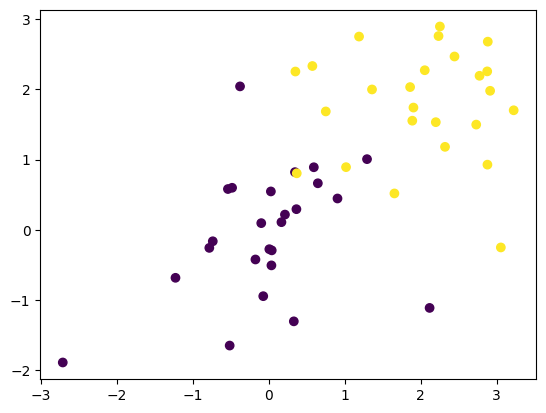

In [6]:
# wykres punktów
plt.scatter(X[:,0], X[:,1], c = y)

### Zadanie 1
-----
Zbuduj model wektorów podpierających wykorzystując zdefinowane X i y jak zbiór treningowy. Ustaw parametr `C` = 10, `kernel` = 'linear'.

In [7]:
# model SVC()
svm_linear = SVC(C = 10, kernel = 'linear')
svm_linear.fit(X, y)

SVC(C=10, kernel='linear')

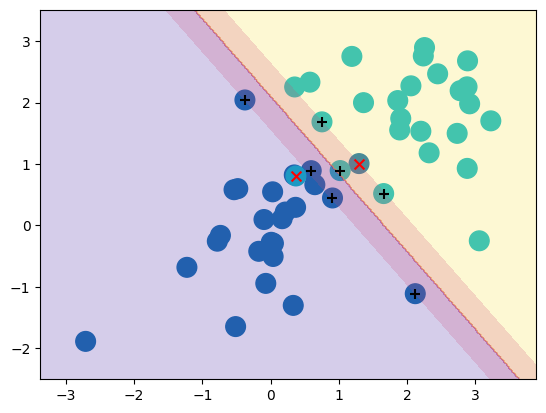

In [8]:
# wykres dla modelu SVM z użyciem pakietu ISLP
from ISLP.svm import plot as plot_svm

fig, ax = plt.subplots()
plot_svm(X, y, svm_linear, ax=ax)

# krzyżykiem są punkty support vectors
# mniejsza wartość parametru C - większa liczba wektorów podpierających

### Wyznaczanie hiperpłaszczyzny (dla dwóch wymiarów)

$<w, x> + b = 0$

$w_1x_1 + w_2x_2 + b = 0$

$w_2x_2 = -w_1x_1 - b$

$x_2 = -\frac{w_1}{w_2}x_1 - \frac{b}{w_2}$


In [9]:
# współczynniki z modelu i wyraz wolny
W = svm_linear.coef_[0]
b = svm_linear.intercept_[0]

# wyliczenie A i B
A = -W[0]/W[1]
B = -b/W[1]

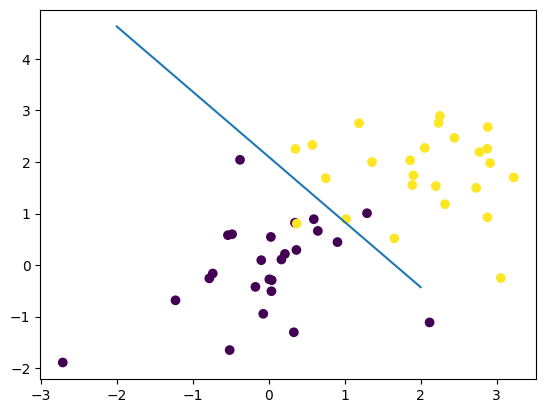

In [10]:
# dorysowanie prostej z modelu
fig, ax = plt.subplots()
plt.scatter(X[:,0], X[:,1], c = y)
ax.plot(np.array([-2,2]), A * np.array([-2,2]) + B)


### Zadanie 2
-----
Wyznacz, które punkty są wektorami podpierającymi i zaznacz je na powyższym wykresie.

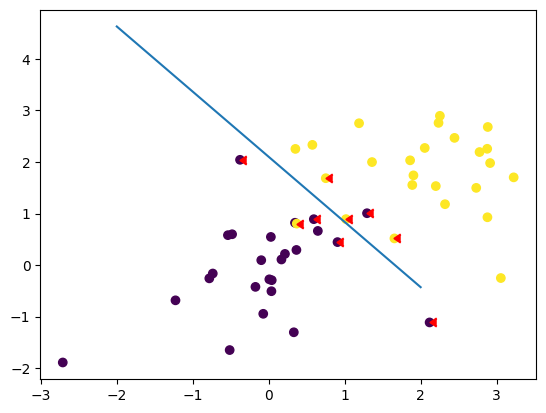

In [11]:
svm_linear.support_ # wskazanie wektorów podpierających

support = X[svm_linear.support_] # wybór z danych
fig, ax = plt.subplots()
plt.scatter(X[:,0], X[:,1], c = y)
ax.plot(np.array([-2,2]), A * np.array([-2,2]) + B)
ax.scatter(support[:,0], support[:,1], marker = 4, color = "red") # dorysowanie wektorów podpierającym

### Zadanie 3
-----
Zbuduj model wektorów podpierających wykorzystując zdefinowane X i y jak zbiór treningowy. Ustaw parametr `C` = 0.01, `kernel` = 'linear'. Narysuj płaszczyznę rozdzielającą klasy i wskaż wektory podpierające. 

In [12]:
# model SVM, hiperparametry C i kernel
from sklearn.svm import SVC
svm_linear_small = SVC(C = 0.01, kernel = 'linear')
svm_linear_small = svm_linear_small.fit(X, y)

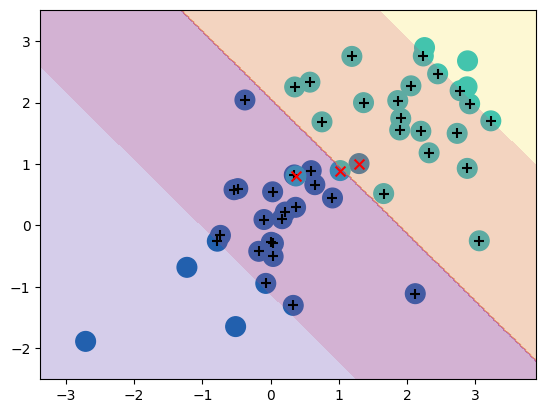

In [13]:
# wykres svm
from ISLP.svm import plot as plot_svm

fig, ax = plt.subplots()
plot_svm(X, y, svm_linear_small, ax=ax)

In [14]:
# wyznaczenie współczynników
W = svm_linear_small.coef_[0]
b = svm_linear_small.intercept_[0]

# wyzaczenie A i B do prostej
A = -W[0]/W[1]
B = -b/W[1]

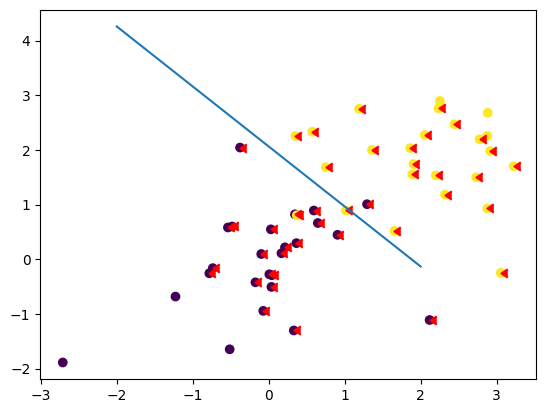

In [16]:

support = X[svm_linear_small.support_]
fig, ax = plt.subplots()
plt.scatter(X[:,0], X[:,1], c = y)
ax.plot(np.array([-2,2]), A * np.array([-2,2]) + B)
ax.scatter(support[:,0], support[:,1], marker = 4, color = "red")

### Wyznaczanie marginesu (dla dwóch wymiarów)

$margin_{magnitude} = \frac{1}{||w||}$

$||w|| = \sqrt{w_1^2 + w_2^2}$

$\hat{w} = \frac{w}{||w||}$


In [17]:
w_hat = svm_linear.coef_[0] / (np.sqrt(np.sum(svm_linear.coef_[0] ** 2)))

In [18]:
margin = 1 / np.sqrt(np.sum(svm_linear.coef_[0] ** 2))

In [19]:
decision_boundary_points = np.array(list(zip(np.array([-3,3]), A * np.array([-3,3]) + B)))
points_of_line_above = decision_boundary_points + w_hat * margin
points_of_line_below = decision_boundary_points - w_hat * margin

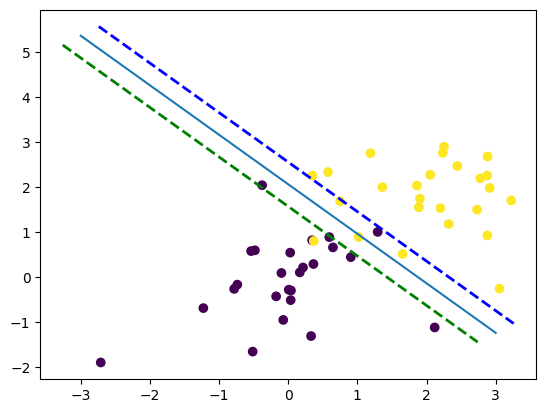

In [20]:
fig, ax = plt.subplots()
plt.scatter(X[:,0], X[:,1], c = y)
ax.plot(np.array([-3,3]), A * np.array([-3,3]) + B)
# Blue margin line above
plt.plot(points_of_line_above[:, 0], 
         points_of_line_above[:, 1], 
         'b--', 
         linewidth=2)
# Green margin line below
plt.plot(points_of_line_below[:, 0], 
         points_of_line_below[:, 1], 
         'g--',
         linewidth=2)

### Optymalizacja parametru C z wykorzystaniem GridSearchCV

In [21]:
# definicja kroswalidacji
import sklearn.model_selection as skm
kfold = skm.KFold(5, # liczba foldów
                  random_state=0, # random state do powtarzalności wyników
                  shuffle=True)

In [22]:
# definicja siatki hiperparametrów
grid = skm.GridSearchCV(svm_linear, # model, którego hiperparametry optymalizujemy
                        {'C':[0.001, 0.01, 0.1, 1, 5, 10, 100]}, # zakres hiperparametrów jak słownik
                         refit=True, # dopasowanie modelu do całych danych treningowych po wybraniu optymalnych hiperparametrów
                         cv=kfold, # informacje o kroswalidacji (komórka kodu wyżej)
                         scoring='accuracy') # miara pod którą optymalizujemy

In [23]:
# dopasowanie modelu z różnymi hiperparamterami do danych
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(C=10, kernel='linear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]},
             scoring='accuracy')

In [24]:
# najlepsze hiperparametry 
grid.best_params_

{'C': 5}

In [25]:
# wyniki całego badania
grid.cv_results_

{'mean_fit_time': array([0.00311122, 0.00107703, 0.00162492, 0.00377684, 0.00263824,
        0.00243506, 0.00432334]),
 'std_fit_time': array([0.0016694 , 0.00138857, 0.00183201, 0.00471465, 0.00259716,
        0.00297283, 0.00417969]),
 'mean_score_time': array([0.00344539, 0.00264473, 0.00204649, 0.00183043, 0.00411177,
        0.00323706, 0.00359488]),
 'std_score_time': array([0.0017712 , 0.00310901, 0.00171157, 0.00292333, 0.00297252,
        0.00412422, 0.00231562]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 5},
  {'C': 10},
  {'C': 100}],
 'split0_test_score': array([0.7, 0.8, 0.7, 0.7, 0.8, 0.8, 0.8]),
 'split1_test_score': array([0.3, 0.8, 1. , 1. , 1. , 1. , 1. ]),
 'split2_test_score': array([0.8, 1. , 1. , 1. , 1. , 1. , 1. ]),
 'split3_test_score': array([0.3, 0.9, 1. , 1. 

In [26]:
# ponieważ wyniki badania są słownikiem, to korzystając z funkcji pd.DataFrame otrzymujemy ładną tabelkę z podsumowaniem
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003111,0.001669,0.003445,0.001771,0.001,{'C': 0.001},0.7,0.3,0.8,0.3,0.9,0.60,0.252982,7
1,0.001077,0.001389,0.002645,0.003109,0.010,{'C': 0.01},0.8,0.8,1.0,0.9,1.0,0.90,0.089443,6
2,0.001625,0.001832,0.002046,0.001712,0.100,{'C': 0.1},0.7,1.0,1.0,1.0,1.0,0.94,0.120000,4
3,0.003777,0.004715,0.001830,0.002923,1.000,{'C': 1},0.7,1.0,1.0,1.0,1.0,0.94,0.120000,4
4,0.002638,0.002597,0.004112,0.002973,5.000,{'C': 5},0.8,1.0,1.0,1.0,1.0,0.96,0.080000,1
5,0.002435,0.002973,0.003237,0.004124,10.000,{'C': 10},0.8,1.0,1.0,1.0,1.0,0.96,0.080000,1
6,0.004323,0.004180,0.003595,0.002316,100.000,{'C': 100},0.8,1.0,1.0,1.0,1.0,0.96,0.080000,1


In [27]:
# sprawdzenie modelu na danych testowych, ponownie losowane z rozkładu normalnego
rng = np.random.default_rng(1)
X_test = rng.standard_normal((20,2))
y_test = np.array([-1]*10 + [1]*10)
X_test[y_test == 1] += 2 #przesunięcie punktów z klasy 1 o [2,2] 


In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score
best_ = grid.best_estimator_ # wybiera najlepszy model ze wszystkich
y_pred_test = best_.predict(X_test) # predykcja na zbiorze testowym
confusion_matrix(y_pred_test, y_test) # macierz pomyłek

array([[10,  1],
       [ 0,  9]], dtype=int64)

In [30]:
# dokładność
accuracy_score(y_test, y_pred_test)

0.95

In [31]:
# porówananie wyniku z modelem z zadania 3
y_pred_test_small = svm_linear_small.predict(X_test)
confusion_matrix(y_pred_test_small, y_test)

array([[10,  2],
       [ 0,  8]], dtype=int64)

In [32]:
accuracy_score(y_test, y_pred_test_small)

0.9

### Podsumowanie, czyli co warto wiedzieć...


1. Idea regresji liniowej
2. Regresja logistyczna

    a) przekształcenie funkcją sigmoid

    b) wyliczanie współczynników metodą ML

    c) regularyzacja L1 + własności (ograniczenie liczby zmiennych)

    d) regularyzacja L2

3. SVM (liniowe)

    a) wyznaczanie hiperpłaszczyzny, marginesu, wektorów podpierających

    b) przypadek danych nieseparowalnych - kara C (analogia do L2)
    
4. Funkcje straty